In [2]:
from keras.layers import Dense
%matplotlib inline
import keras
from keras.models import Sequential
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import scipy
import math
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import load_model
from sklearn.metrics import confusion_matrix

from IPython.display import clear_output

In [3]:
path_text='../Text-detection-in-natural-scene-images-dataset/text or no text dataset/english_base/'
path_notext = '../Text-detection-in-natural-scene-images-dataset/text or no text dataset/no_text_base/'

files = os.listdir(path_text)[1:]
files_notext = os.listdir(path_notext)[1:]

print(len(files))
print(len(files_notext))
#print(files)

text_data = pd.DataFrame(np.empty((1,1024)))
non_text_data = pd.DataFrame(np.empty((1,1024)))

3501
4990


In [4]:
i=0
for images in files:
    img = np.asarray(Image.open(path_text+images).resize((32,32),Image.ANTIALIAS))
    text_data.loc[i,:] = img.ravel()
    i+=1
    #print("i *** in text images", i)
print("Done for text images")
i=0
for images in files_notext:
    img = np.asarray(Image.open(path_notext+images).convert('L').resize((32,32),Image.ANTIALIAS))
    non_text_data.loc[i,:] = img.ravel()
    i+=1
    #print("i *** in nontext images", i)

print("Done for non text images")

Done for text images
Done for non text images


In [62]:
non_text_data['text_label'] = 0
text_data['text_label'] = 1

In [63]:
data = pd.concat([text_data,non_text_data])

In [64]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(data.iloc[:,:1024],data['text_label'],test_size=0.1)

In [65]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
train_x = sc_x.fit_transform(train_x)
test_x = sc_x.transform(test_x)

from sklearn.externals import joblib
joblib.dump(sc_x , './my_scaler_base_2.pkl') 

['./my_scaler_base_2.pkl']

In [66]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure(figsize=(800/96, 800/96), dpi=96)
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        #ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

# Using CNN for the classification algorithm

In [67]:
train_x1 = train_x.reshape((train_x.shape[0],32,32,1))
test_x1 = test_x.reshape((test_x.shape[0],32,32,1))

In [68]:
clf1 = Sequential()
clf1.add(Convolution2D(32,(3,3),input_shape=(32,32,1),activation='relu'))
clf1.add(MaxPooling2D(2,2))
clf1.add(Convolution2D(128,(3,3),activation='relu'))
clf1.add(MaxPooling2D(2,2))
clf1.add(Flatten())
clf1.add(Dense(activation='relu',units=500,kernel_initializer='uniform'))
clf1.add(Dense(units=1,kernel_initializer='uniform',activation='sigmoid'))
clf1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

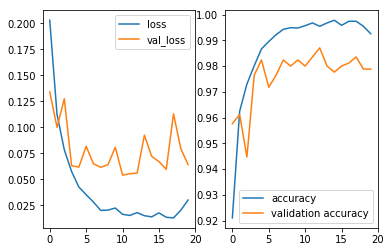

In [69]:
clf1.fit(train_x1, train_y, epochs=20, validation_data=(test_x1, test_y), callbacks=[plot], verbose=0)
clf1.save('./my_model_base_2.h5')

In [70]:
y_pred1 = np.around(clf1.predict(test_x1))

In [71]:
confusion_matrix(test_y,y_pred1)

array([[493,  10],
       [  8, 339]])

# Now we'll try to apply this model on a few images

In [84]:
img = cv2.imread('../Text-detection-in-natural-scene-images-dataset/text or no text dataset/test images/26041.jpg',0)

#a = input('Bright text on dark background? Press Y/y for yes and any other key for no.' )
# if a=='y' or a=='Y':
#     otsu_1 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
# #     th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,25,3)
# else:
#     otsu_1 = 255-cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
# #     th2 = 255- cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,25,3)


otsu_1 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,25,3)
# connected components
cc  = cv2.connectedComponents(np.uint8(th2))[1]

# creating imgage for every single label in the connected components
con_img = {}
for label in np.unique(cc[cc>0]):
    image = np.zeros(cc.shape)
    indices = np.where(cc==label)
    image[indices] = 1
    con_img[label] = image
    

# plt.savefig('plot_3.jpg')

# plt.figure(figsize=[20,10])
# plt.subplot(1,3,1)
# plt.imshow(img)

# plt.subplot(1,3,2)
# plt.imshow(otsu_1)

# plt.subplot(1,3,3)
# plt.imshow(cc)


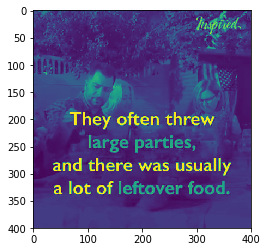

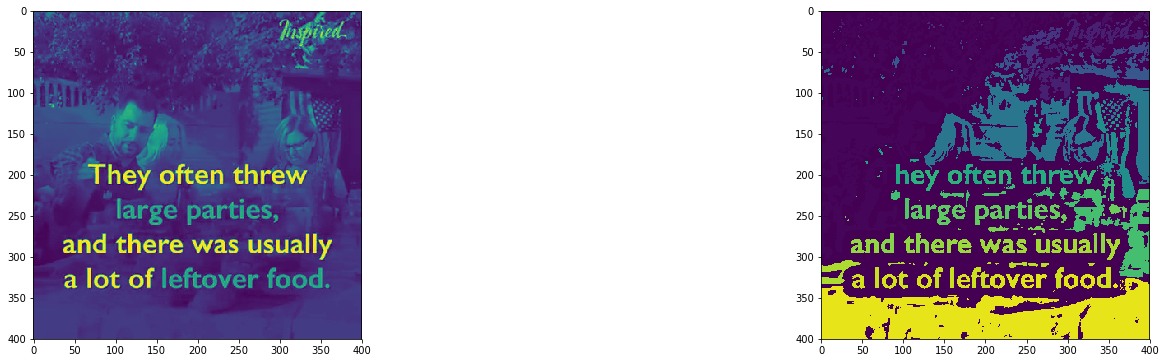

In [85]:
# img    =    cv2.imread('../Text-detection-in-natural-scene-images-dataset/text or no text dataset/test images/1.jpg',0)
plt.imshow(img)
plt.figure(figsize=[20,10])
plt.subplot(1,3,1)
plt.imshow(img)

# plt.subplot(1,3,2)
# plt.imshow(otsu_1)

plt.subplot(1,3,3)
plt.imshow(cc)

#print(con_img)

/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]
/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo
yuhoo


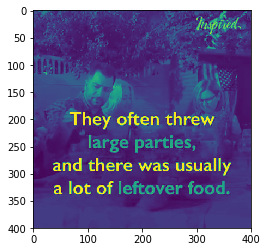

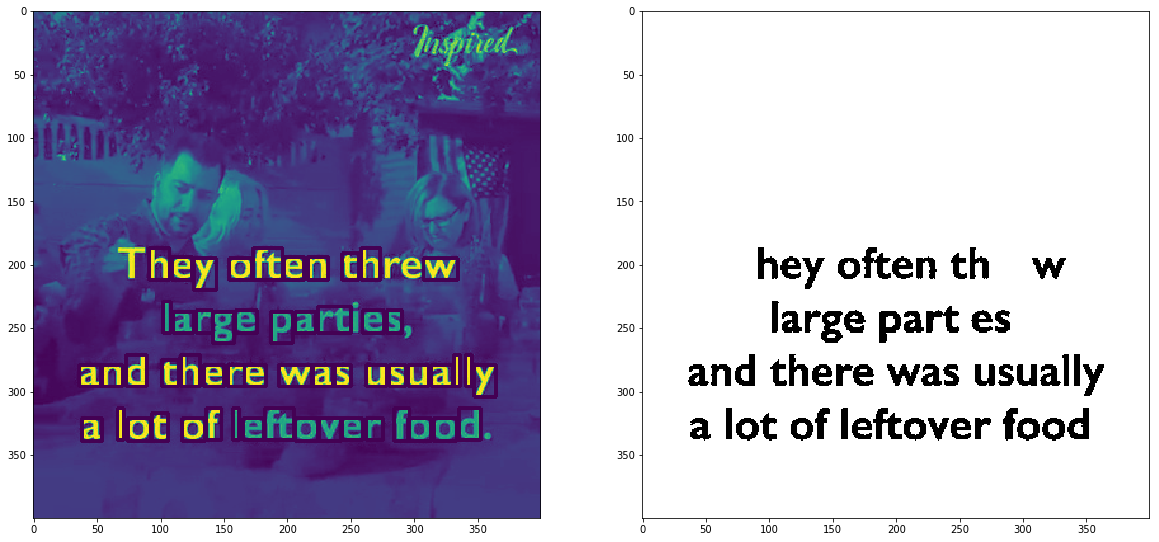

In [86]:
plt.imshow(img)

tot1=0
i=1
mask = {}
i=1
model = load_model('./my_model_base_2.h5')
loaded_scaler = joblib.load('./my_scaler_base_2.pkl')
for elem in con_img.keys():
    x,y,w,h = cv2.boundingRect(np.uint8(con_img[elem]))
    #print("****", x, y, w, h)
    imng = img[y:y+h,x:x+w]
    imng =  scipy.misc.imresize(imng,(32,32)).ravel().reshape(1,1024)
    imng = loaded_scaler.transform(imng)
    imng = imng.reshape((1,32,32,1))
#     print(elem,np.around(classifier.predict(imng)))
    if np.around(model.predict(imng)) == 1.0:
        print('yuhoo')
        tot1+=con_img[elem]
#         mask[i]=con_img[elem]
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        i+=1
        

tot1 = cv2.bitwise_not(tot1)

plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(tot1,'gray')